# Librairies

In [154]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import openmc

from scipy.constants import Avogadro



# Ajout des matériaux

In [155]:
aluminum = openmc.Material()
aluminum.add_element('Al', 1)
aluminum.set_density('g/cm3', 2.7)

sodium_iodide = openmc.Material()
sodium_iodide.add_element('Na', 1)
sodium_iodide.add_element('I', 1)
sodium_iodide.set_density('g/cm3', 3.667)

aluminum_oxide = openmc.Material()
aluminum_oxide.add_nuclide('O16', 0.4) 
aluminum_oxide.add_element('Al', 0.6)
aluminum_oxide.set_density('g/cm3', 3.97)

iron = openmc.Material()
iron.add_element('Fe', 1)
iron.set_density('g/cm3', 7.874)

mats = openmc.Materials([aluminum, sodium_iodide, aluminum_oxide, iron])
mats.export_to_xml()

# Définition des matériaux 

In [156]:
# Defining surfaces
c1 = openmc.ZCylinder(r=3.81)
c2 = openmc.ZCylinder(r=3.86)
c3 = openmc.ZCylinder(r=3.91)

z1 = openmc.ZPlane(z0=0.00)
z2 = openmc.ZPlane(z0=0.05)
z3 = openmc.ZPlane(z0=0.10)
z4 = openmc.ZPlane(z0=7.72)
z5 = openmc.ZPlane(z0=7.77)
z6 = openmc.ZPlane(z0=8.00)

s = openmc.Sphere(r=11, boundary_type='vacuum')

In [157]:
# Defining cells
sodium_iodide_crystal = openmc.Cell()
sodium_iodide_crystal.region = -c1 & -z4 & +z3
sodium_iodide_crystal.fill = sodium_iodide

aluminum_casing = openmc.Cell()
aluminum_casing.region = (+c2 & -c3 & -z4 & +z2) | (-c3 & -z2 & +z1)
aluminum_casing.fill = aluminum

oxide_layer = openmc.Cell()
oxide_layer.region = (+c1 & -c2 &-z4 & +z2) | (-c2 & -z3 & +z2)
oxide_layer.fill = aluminum_oxide

detector_back = openmc.Cell()
detector_back.region = -c3 & -z6 & +z4
detector_back.fill = iron

surrounding = openmc.Cell()
surrounding.region = -s & ~(-c3 & -z6 & +z1)

In [158]:
universe = openmc.Universe(cells=[sodium_iodide_crystal, aluminum_casing, oxide_layer, oxide_layer, detector_back, surrounding])
geometry = openmc.Geometry(universe)
geometry.export_to_xml()

# Définition de la source 

In [159]:
source_1 = openmc.Source()
source_1.space = openmc.stats.Point((0.0, 0.0, -10.0))
source_1.angle = openmc.stats.Monodirectional([0.0, 0.0, 1.0])
source_1.energy = openmc.stats.Discrete([800_000.0], [1.0])

source_1.strength = 1e6
source_1.particle = 'photon'

/opt/anaconda3/envs/openmc-ppm/lib/python3.11/site-packages/openmc/source.py:658: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


In [160]:


source_2_Cs137 = openmc.Source()
source_2_Cs137.space = openmc.stats.Point((-1.0, 0.0, 0.0))
source_2_Cs137.angle = openmc.stats.Isotropic()
source_2_Cs137.energy = openmc.stats.Discrete([661_700], [1.0])
source_2_Cs137.particle = 'photon'


In [161]:
settings = openmc.Settings()
settings.particles = 10**3
settings.batches = 10
settings.photon_transport = True
settings.source = [source_1, source_2_Cs137]
settings.run_mode = 'fixed source'
settings.export_to_xml()

In [162]:
tallies = openmc.Tallies()

energy_bins = np.linspace(0, 1e6, 1001)
energy_filter = openmc.EnergyFilter(energy_bins)
cell_filter = openmc.CellFilter(sodium_iodide_crystal)

tally = openmc.Tally(name='pulse-height')
tally.filters = [cell_filter, energy_filter]
tally.scores = ['pulse-height']
tallies.append(tally)
tallies.export_to_xml()

In [163]:
openmc.run()

python(10009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

KeyboardInterrupt: 

In [ ]:
sp = openmc.StatePoint('statepoint.10.h5')
tally = sp.get_tally(name='pulse-height')
pulse_height_values = tally.get_values(scores=['pulse-height']).flatten()

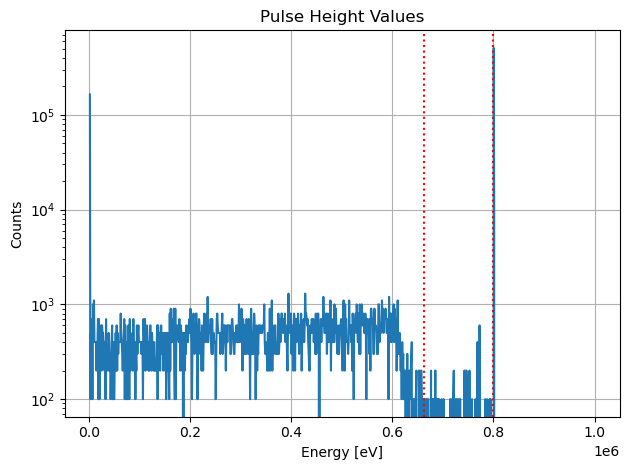

In [ ]:
# we want to display the pulse-height value in the center of the bin
energy_bin_centers = energy_bins[1:] + 0.5 * (energy_bins[1] - energy_bins[0])

plt.figure()
plt.semilogy(energy_bin_centers, pulse_height_values)

# plot the strongest sources as vertical lines
plt.axvline(x=800_000, color="red", ls=":")     # source_1
plt.axvline(x=661_700, color="red", ls=":")     # source_2

plt.xlabel('Energy [eV]')
plt.ylabel('Counts')
plt.title('Pulse Height Values')
plt.grid(True)
plt.tight_layout()